In [6]:
import requests
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math


estate_data = pd.read_csv("estate_data4.csv")
data = pd.DataFrame(estate_data)
# print(estate_data['noBed'])

#--------------------------------------------------------------------------------------------------------------
#get the post code
def get_post_code(value):
    list_result = value.split()
    return " ".join(list_result[-2:])

data['postCode'] = data['address'].apply(get_post_code)

#transfer sold price
def transfer_price(value):
    price = int(value[1:].replace(',',''))
    return price

data['soldPrice'] = data['soldPrice'].apply(transfer_price)

#deal with the bedroom
def deal_bedroom(value):
    bedroom_num = (str(value)).split()[0]
    return bedroom_num

data['noBed'] = data['noBed'].apply(deal_bedroom)

#----------------------------------------clean data--------------------------------------------------------------
def get_year(value):
    year = value[-2:]
    return year

data['soldYear'] = data['soldDate'].apply(get_year)

sorted_df = data[data['soldYear'] > '11']
# sorted_df = sorted_df.dropna(subset = ['noBed'])

index_numbers = pd.Series([x for x in range(len(sorted_df))])
new_data = sorted_df.set_index(index_numbers)

new_data['soldYear'] = new_data['soldYear'].astype(int)
#new_data['noBed'] = new_data['noBed'].astype(int)
new_data = new_data.drop(['address','soldDate'], axis=1)
new_data = new_data[new_data['noBed'] != 'nan']

#---------------------merge with ukpostcodes.csv----------------------------------------
ukpostcodes_df = pd.read_csv("ukpostcodes.csv")
ukpostcodes_df = ukpostcodes_df.drop('id',axis=1)
data_df = pd.merge(new_data,ukpostcodes_df,how="left", left_on="postCode",right_on="postcode")
# data_df.to_csv('data_df.csv',header=True,index=False)

# deal with holdType : Freehold :0 ,Leasehold :1
data_df['holdType'] = data_df['holdType'].str.strip()
def holdType(value):
    if value == 'Freehold':
        return 1
    elif value == 'Leasehold':
        return 2
    else:
        return value

# data_df['holdType'] = data_df['holdType'].replace('Freehold',0,inplace=True)
data_df['holdType'] = data_df['holdType'].map(holdType)

#deal with homeType: Semi-Detached:0,Detached:1,Terraced:2,Flat:3
def homeType(value):
    if value == 'Semi-Detached':
        return 1
    elif value == 'Detached':
        return 2
    elif value == 'Terraced':
        return 3
    elif value == 'Flat':
        return 4
    else:
        return value

data_df['homeType'] = data_df['homeType'].map(homeType)

# deal with usage: Residential:0 , Residential\xa0(New Build):1
data_df['usage'] = data_df['usage'].str.strip()

def usage(value):
    if value == 'Residential':
        return 1
    elif value == 'Residential\xa0(New Build)':
        return 2
    else:
        return value

data_df['usage'] = data_df['usage'].map(usage)

#------------------------------build model with liner regression------------------------------------------
new_data_df = data_df[['holdType','homeType','noBed','soldPrice','usage','latitude','longitude']]
x_train = new_data_df[['holdType','homeType','noBed','usage','latitude','longitude']]
y_train = new_data_df['soldPrice'].apply(math.log)

linear_regression = LinearRegression()
linear_regression.fit(x_train,y_train)
y_predict_test = linear_regression.predict(x_train)
#---------------get the score for this model-----------------------
score = linear_regression.score(x_train,y_train)
a = linear_regression.predict([[1,1,2,1,50.953005,-2.641757]])

In [36]:
a

array([12.00823651])

In [68]:
X = new_data_df.drop(['soldPrice'], axis = 1)  # all rows, no label
y = new_data_df['soldPrice']  # all rows, label only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

predictions = linear_regression.predict(X_test)
predictions

array([12.15294427, 12.45991071, 12.31249764, ..., 11.66946533,
       12.18351918, 12.37206983])

In [77]:
def get_predictions(predictions):
    predictions_list = []
    for i in predictions:
        a=round(math.exp(i))
        predictions_list.append(a)
    return predictions_list

predictions = get_predictions(predictions)
print(predictions)

[189652, 257793, 222459, 166776, 280425, 152428, 294931, 212357, 280092, 239163, 304832, 178351, 131767, 166686, 233763, 238140, 279081, 184100, 236616, 281303, 332942, 142580, 191371, 393362, 246757, 199212, 246959, 192838, 236121, 135287, 309018, 329477, 130577, 110617, 245380, 183246, 182895, 87408, 196228, 182951, 186487, 117784, 111285, 291667, 318232, 329394, 329477, 147910, 244956, 188645, 240544, 199122, 252174, 239178, 364963, 146157, 186453, 232359, 142841, 267043, 241081, 359148, 151461, 331374, 181771, 149318, 212134, 300557, 148705, 200916, 246411, 227884, 300146, 280264, 287221, 145440, 182767, 194532, 355723, 231056, 156605, 183340, 208536, 247098, 224951, 332599, 149786, 186359, 202705, 257359, 332472, 237060, 257435, 164930, 171121, 396655, 191418, 120297, 257200, 200150, 285365, 113703, 148887, 278801, 201991, 307454, 332421, 212167, 190627, 105142, 175723, 276856, 210515, 280369, 171261, 182086, 385631, 272504, 210474, 182561, 128223, 245437, 184973, 267939, 391310, 

In [76]:
def real_value():
    real_value_list = []
    for i in y_test:
        real_value_list.append(i)
    return real_value_list

real_value = real_value()
print(real_value)

[180000, 276500, 490000, 126000, 265000, 160000, 295000, 158200, 228000, 215000, 340000, 165000, 125000, 178000, 283000, 190000, 289950, 177000, 234000, 267500, 342000, 154500, 255000, 335000, 248000, 257950, 320000, 157000, 263000, 127500, 267500, 310000, 91000, 129000, 250000, 161500, 100000, 100000, 175000, 171500, 187500, 98000, 85000, 223500, 385000, 360000, 245000, 198000, 285000, 199950, 233000, 238000, 189000, 186000, 242500, 210000, 164000, 258000, 110000, 319950, 255000, 500000, 195000, 260000, 155000, 159950, 214000, 225000, 195000, 177000, 262500, 330000, 250000, 250000, 255000, 78500, 193500, 190000, 112500, 229950, 162500, 151000, 180000, 195000, 164000, 196000, 197400, 155000, 205000, 188000, 410000, 228000, 289950, 142500, 380000, 412500, 360000, 174000, 197000, 165000, 399950, 192500, 188000, 230000, 287000, 650000, 410000, 240500, 193000, 116250, 225000, 300000, 188000, 199000, 275000, 144250, 303000, 172500, 200000, 230000, 81000, 250000, 190000, 275000, 775000, 1935

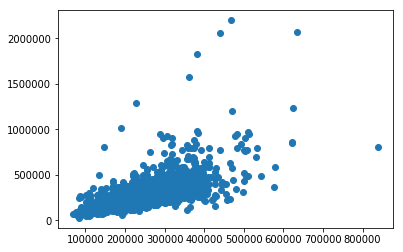

In [78]:
#relationship between predictions and real price
plt.scatter(predictions,real_value)

In [83]:
# caculate the MSE
sum_list=[]
for i in range(len(predictions)):
    sum_num = ((predictions[i]-real_value[i])**2)
    sum_list.append(sum_num)
total = sum(sum_list)

In [85]:
mse = total / len(predictions)
mse

11001221424.52469